# Libraries and Imports

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"

In [2]:
import editdistance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from llms.dna_translator.gpt import DNATranslatorGPT
from schemas.train_params import TrainParams

# Params and Files

In [3]:
seed = 42

csv_path = "tran-1000.csv"
pretrained_model_name = "DNATranGPT"

In [4]:
csv_path = f"./storage/data/processed/{csv_path}"
output_path = f"./storage/models/tuned/{pretrained_model_name}"
checkpoint = "./storage/models/base/gpt2"

# Reading Dataset

In [5]:
df = pd.read_csv(csv_path, keep_default_na=False)

# Loading Model

In [6]:
llm = DNATranslatorGPT(
  checkpoint=checkpoint,
  seed=seed
)

# Data Processing

In [7]:
data = df.to_dict(orient="records")

In [8]:
all_dataset = []
for record in tqdm(data):
	example = llm.build_input(
		dna_sequence=record["sequence"],
		organism=record["organism"],
		protein_sequence=record["target"]
	)
	all_dataset.append(example)

train_eval, test_dataset = train_test_split(
	all_dataset,
	test_size=0.15,
	random_state=seed,
	shuffle=True
)

eval_size = 0.05 / 0.85

train_dataset, eval_dataset = train_test_split(
	train_eval,
	test_size=eval_size,
	random_state=seed,
	shuffle=True
)

100%|██████████| 244090/244090 [00:00<00:00, 1919307.97it/s]


# Data Analysis

In [9]:
print("Train Dataset Len:", len(train_dataset))
print("Eval Dataset Len:", len(eval_dataset))
print("Test Dataset Len:", len(test_dataset))

Train Dataset Len: 195271
Eval Dataset Len: 12205
Test Dataset Len: 36614


In [10]:
train_lengths = [len(example["dna_sequence"]) for example in train_dataset]
eval_lengths = [len(example["dna_sequence"]) for example in eval_dataset]
test_lengths = [len(example["dna_sequence"]) for example in test_dataset]

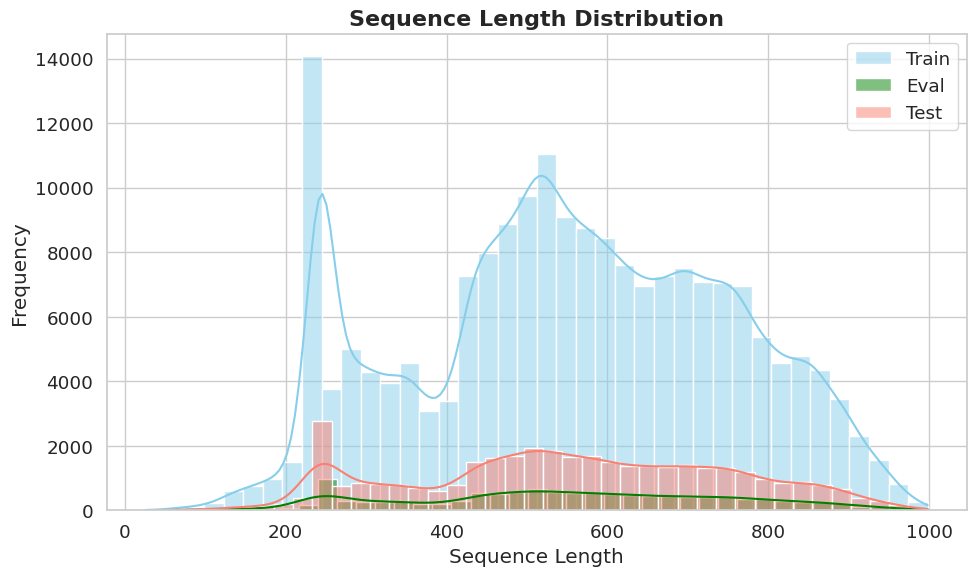

In [11]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(eval_lengths, kde=True, bins=40, color="green", label="Eval")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [12]:
llm.train(
  train_dataset=train_dataset,
  params=TrainParams(
    epochs=15,
    batch_size=4,
    gradient_accumulation=1,
    lr=4e-5,
    logging_steps=50000
	),
  eval_dataset=eval_dataset
)

2025-12-30 09:16:53,343 - INFO - Preparing train dataset...
100%|██████████| 195271/195271 [10:12<00:00, 318.83it/s]
2025-12-30 09:27:22,609 - INFO - Train dataset prepared!
2025-12-30 09:27:22,610 - INFO - Preparing eval dataset...
100%|██████████| 12205/12205 [00:38<00:00, 320.43it/s]
2025-12-30 09:28:01,512 - INFO - Eval dataset prepared!
2025-12-30 09:28:01,943 - INFO - Starting training...
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,No log,1.408324
2,2.494400,0.151833
3,0.765900,0.106399
4,0.174300,0.089137
5,0.126600,0.075501
6,0.101600,0.065077
7,0.083800,0.059089
8,0.071700,0.055533
9,0.063100,0.052382
10,0.056000,0.049662


2026-01-01 06:47:52,108 - INFO - Training complete. You may save the model for later usage.


# Saving The Model

In [16]:
llm.save_pretrained("15-epoch-gpt-2")

2026-01-01 06:48:45,921 - INFO - Attempting to save model at '15-epoch-gpt-2'
2026-01-01 06:48:50,781 - INFO - Successfully saved at '15-epoch-gpt-2'


# Test Without Blast

In [13]:
#from blast_analysis import blast_analysis
results = []

for data in tqdm(test_dataset[:100]):
	pred = llm.generate(data)
	target = data["protein_sequence"]

	dist = editdistance.eval(pred, target)
	similarity = 1 - dist / max(len(pred), len(target))

	#blast_results = blast_analysis(
	#	pred=pred,
	#	target=target
	#)

	results.append({
		"target": target,
		"pred": pred,
		"edit_dist": dist,
		"similarity": similarity,
		#**blast_results
	})

100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


In [14]:
similarities = [r["similarity"] for r in results]
mean_similarity = np.mean(similarities)
std_similarity = np.std(similarities)

print(f"Mean similarity: {mean_similarity:.4f} ± {std_similarity:.4f}")

Mean similarity: 0.6297 ± 0.3790
